In [1]:
import sys
base_path = '/Users/yuri/git/diasYuri/tcc/radiation-forecast-mg'
sys.path.insert(0, base_path)

https://colab.research.google.com/github/charlesollion/dlexperiments/blob/master/7-Transformers-Timeseries/Transformers_for_timeseries.ipynb

https://github.com/cure-lab/LTSF-Linear/blob/main/models/Transformer.py

https://github.com/Masterleia/TSF_LSTF_Compare/tree/main


https://github.com/PacktPublishing/Modern-Time-Series-Forecasting-with-Python

In [2]:
from src.dataframe import read_data_from_csv
from sklearn.preprocessing import MinMaxScaler
from src.transformers import TransformerModel, TemporalSerie, EarlyStopper
from src.dataframe import show_error_metrics
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

import matplotlib.pyplot as plt
import numpy as np

In [3]:
df = read_data_from_csv(f'{base_path}/data/daily_juiz de fora.csv', fill=True)
df

,RADIATION,TEMP,HUMIDITY_h
Timestamp,,,
2007-05-26,35796.9,17.258333,54.666667
2007-05-27,11666.6,14.529167,81.958333
2007-05-28,14929.7,15.662500,84.500000
2007-05-29,10491.4,16.554167,85.666667
2007-05-30,8048.6,11.283333,88.500000
...,...,...,...
2022-12-27,17162.9,19.979167,89.125000
2022-12-28,16095.1,20.783333,85.416667
2022-12-29,11308.1,20.575000,88.583333


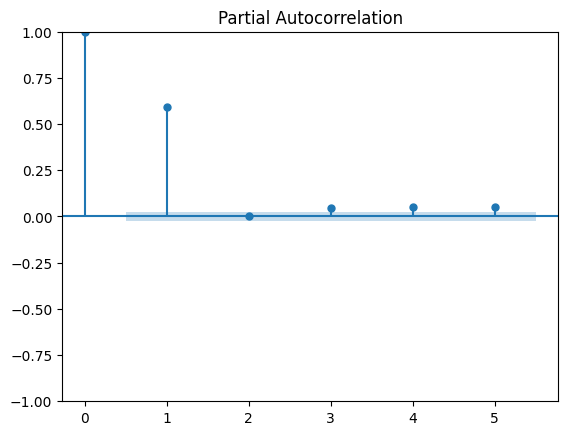

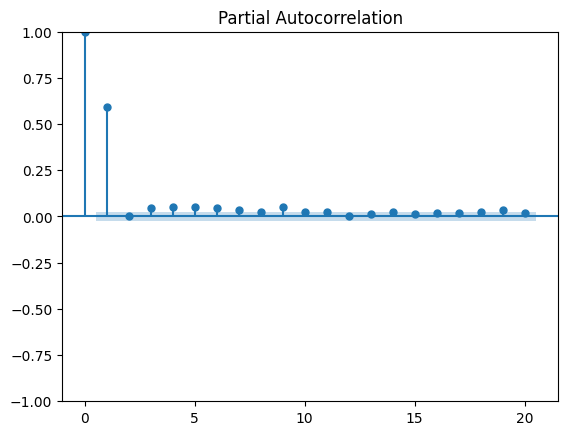

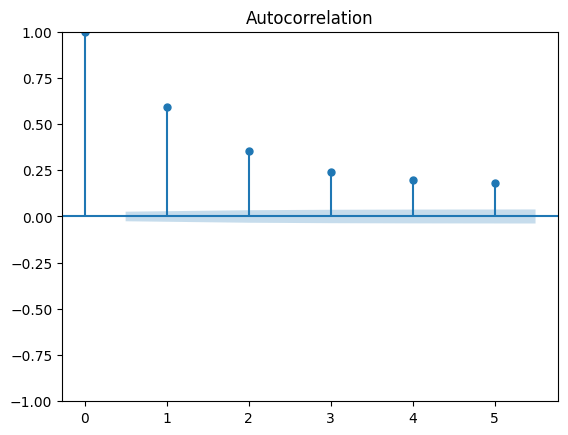

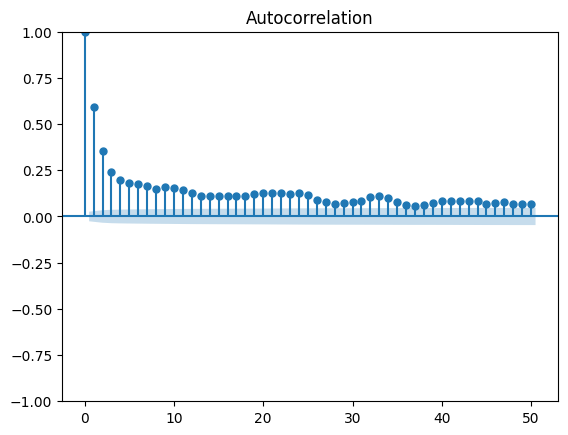

In [4]:
plot_pacf(df.RADIATION, lags=5, method="ywm")
plot_pacf(df.RADIATION, lags=20, method="ywm")

plot_acf(df.RADIATION, lags=5)
plot_acf(df.RADIATION, lags=50)

plt.show()

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(df["RADIATION"].values.reshape(-1, 1))

In [6]:
data

array([[0.67375802],
       [0.20049424],
       [0.26449291],
       ...,
       [0.19346304],
       [0.10251044],
       [0.3528115 ]])

In [7]:
length = len(data)
rate = 0.8
 
train_length = (int)(length*0.7)
validation_length = (int)(length*0.2)
test_length = (int)(length*0.1)

train, validation, test = data[:train_length], data[train_length:train_length+validation_length], data[train_length+validation_length:]

In [8]:
train = TemporalSerie(train, 3)
validation = TemporalSerie(validation, 3)
test = TemporalSerie(test, 3)

In [9]:
model = TransformerModel(d_model=16, 
                         nhead=8, 
                         num_encoder_layers=8, 
                         num_decoder_layers=8, 
                         dropout=0.2)

('Epoch: 0 | Train loss: 0.035083395935595035 | Validation loss: 0.016599763558626596',)
('Epoch: 1 | Train loss: 0.021338567479513584 | Validation loss: 0.01633868523886506',)
('Epoch: 2 | Train loss: 0.019904981893021614 | Validation loss: 0.016223849545062428',)
('Epoch: 3 | Train loss: 0.01924252315238118 | Validation loss: 0.01622236466927218',)
('Epoch: 4 | Train loss: 0.01887146086059511 | Validation loss: 0.016297633648181046',)
('Epoch: 5 | Train loss: 0.01866923950333148 | Validation loss: 0.016353104197957987',)
('Epoch: 6 | Train loss: 0.018472375630401074 | Validation loss: 0.016271710759815827',)
('Epoch: 7 | Train loss: 0.018387700435705482 | Validation loss: 0.016281879946432064',)
('Epoch: 8 | Train loss: 0.01822490742895752 | Validation loss: 0.016271603155986105',)
('Epoch: 9 | Train loss: 0.018102953899651764 | Validation loss: 0.016288778288814594',)
('Epoch: 10 | Train loss: 0.01811310577671975 | Validation loss: 0.01626994538212746',)
('Epoch: 11 | Train loss: 0.

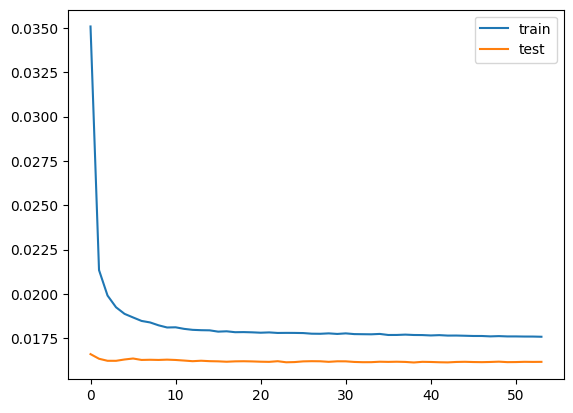

In [10]:
history = model.fit_with_es(train, validation, epochs=100, es=EarlyStopper(patience=15), learning_rate=0.001, verbose=1)

plt.plot(history['train_loss'], label='train')
plt.plot(history['validation_loss'], label='test')
plt.legend()
plt.show()

In [11]:
predict = model.predict(test)

In [12]:
test_value = np.array([t for s, t in test])

In [13]:
len(test_value), len(predict)

(568, 568)

Test R2: -0.000
Test MSE: 0.016
Test RMSE: 0.126
Test MAE: 0.102
Test MAPE: 0.586
Test R2: -0.000
Test MSE: 41513896.000
Test RMSE: 6443.128
Test MAE: 5220.241
Test MAPE: 0.459


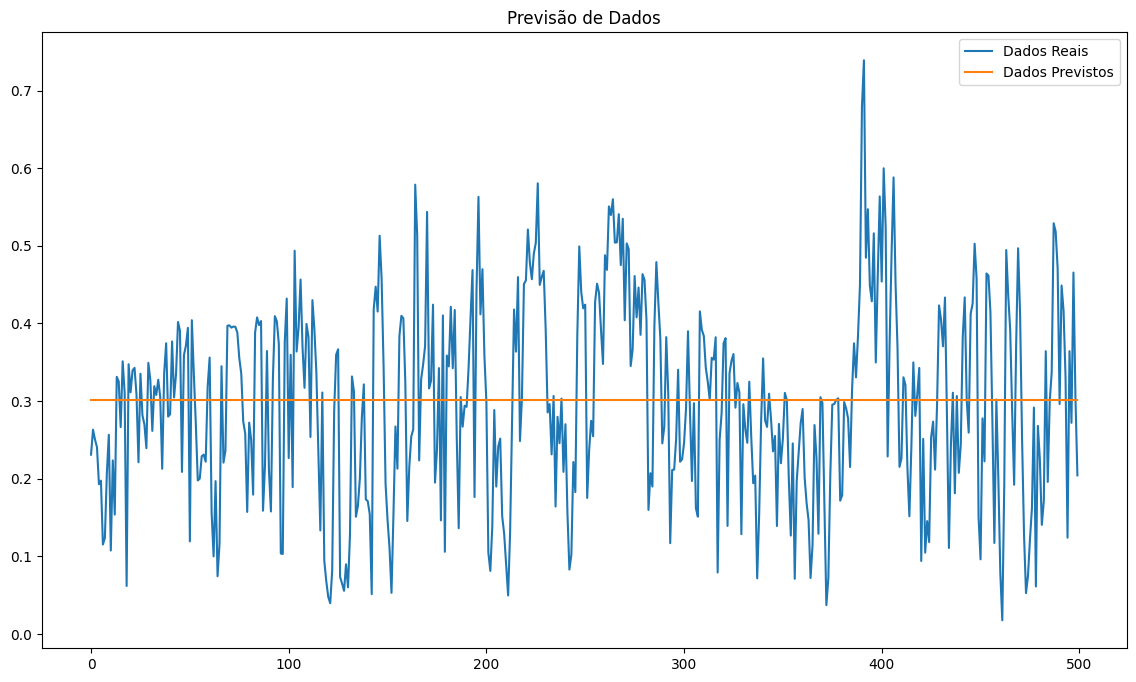

In [14]:
show_error_metrics(test_value.reshape(-1,1), predict)

previsoes = scaler.inverse_transform(predict)
dados_reais = scaler.inverse_transform(test_value.reshape(-1,1))

show_error_metrics(dados_reais, previsoes)

range = 500

plt.figure(figsize=(14, 8))
plt.plot(test_value.reshape(-1,1)[:range], label='Dados Reais')
plt.plot(predict[:range], label='Dados Previstos')
plt.legend()
plt.title('Previsão de Dados')
plt.show()